<b>Data mining project - 2020/21</b><br>
<b>Authors</b>: [Alexandra Bradan](https://github.com/alexandrabradan), [Alice Graziani](https://github.com/alicegraziani25) and [Eleonora Cocciu](https://github.com/eleonoracocciu)<br>
<b>Python version</b>: 3.x<br>
<b>Last update: 21/05/2021<b>

In [414]:
# system library
import os
import sys
import json

# useful libraries
import math
import operator
import itertools
import statistics
import collections
from collections import Counter
from collections import OrderedDict

# pandas
import pandas as pd

# numpy
import numpy as np
from numpy import std
from numpy import mean
from numpy import percentile

# visualisarion
import pydotplus
import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import Image

# sklearn
import sklearn
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix

# dimensional reducers
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif  # classification
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression  # regression

# scalers
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.calibration import CalibratedClassifierCV

# performance visualisation 
from sklearn import tree
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve
from sklearn.model_selection import learning_curve
from mlxtend.plotting import plot_decision_regions
from yellowbrick.model_selection import LearningCurve
from sklearn.metrics import auc, roc_curve, roc_auc_score, f1_score, precision_score, recall_score

# tree classifiers
from sklearn.tree import DecisionTreeClassifier

# linear classifiers
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

# neighbors classifiers
from sklearn.neighbors import KNeighborsClassifier

# naive_bayes classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# ensemble classifiers
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier

# svm
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

# neural network and deep neural network
import tensorflow as tf
from keras import backend as K
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.neural_network import MLPClassifier
from keras.wrappers.scikit_learn import KerasClassifier

plt.rcParams["patch.force_edgecolor"] = True
%matplotlib inline

from yellowbrick.style import set_palette
set_palette('bold')

<h6> Global parameters </h6>

In [322]:
n_iter = 10
scoring = 'f1_weighted'
random_state = 42

# test_n_splits = 9
test_n_splits = 3

model_name = "KerasClassifier"

learning_curve_flag = False
v_or_t_flag = "TST"
cmap = plt.cm.Greys
color = "grey"

<h6> Datasets loading </h6>

In [323]:
X_train = pd.read_csv('../../data/fma_metadata/X_train_merged.csv', index_col=0)
X_test = pd.read_csv('../../data/fma_metadata/X_test.csv', index_col=0)

y_train = pd.read_csv('../../data/fma_metadata/y_train_merged.csv', index_col=0)
y_test = pd.read_csv('../../data/fma_metadata/y_test.csv', index_col=0)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

X_train_vt = pd.read_csv('../../data/fma_metadata/X_train_merged_vt.csv', index_col=0)
X_test_vt = pd.read_csv('../../data/fma_metadata/X_test_vt.csv', index_col=0)

print(X_train_vt.shape, X_test_vt.shape)
print(y_train.shape, y_test.shape)

(92834, 55) (10874, 55)
(92834, 1) (10874, 1)
(92834, 28) (10874, 28)
(92834, 1) (10874, 1)


<h6>Continous, categorical/ordinal column retrieval</h6>

In [324]:
numeric_columns = []  # continous variables
for column_name in X_train.columns:
    if ("track_genre_top" not in column_name) and  \
          ("track_date_created_year" not in column_name) and \
            ("track_date_created_season" not in column_name):
                numeric_columns.append(column_name)
print("numeric_columns", len(numeric_columns))

numeric_columns 37


In [325]:
categoric_columns = []  # ordinal or categorical variables
for column_name in X_train.columns:
    if ("track_genre_top" in column_name) or  \
          ("track_date_created_year" in column_name) or \
            ("track_date_created_season" in column_name):
                categoric_columns.append(column_name)
print("categoric_columns", len(categoric_columns))

categoric_columns 18


In [326]:
numeric_columns_vt = list(set(numeric_columns).intersection(set(X_train_vt.columns)))
print("numeric_columns_vt", len(numeric_columns_vt))

numeric_columns_vt 15


In [327]:
categoric_columns_vt = list(set(categoric_columns).intersection(set(X_train_vt.columns)))
print("categoric_columns_vt", len(categoric_columns_vt))

categoric_columns_vt 13


In [328]:
# UPDATE NUMERIC COLUMNS VERSION 
"""ordinal_columns = ['track_date_created_year', 'track_date_created_season']
numeric_columns = ordinal_columns + numeric_columns
numeric_columns_vt = ordinal_columns + numeric_columns_vt"""

"ordinal_columns = ['track_date_created_year', 'track_date_created_season']\nnumeric_columns = ordinal_columns + numeric_columns\nnumeric_columns_vt = ordinal_columns + numeric_columns_vt"

<h6>Define current (filtered) train and test</h6>

In [329]:
X_tr = X_train[numeric_columns].copy()
y_tr = y_train.copy()
X_ts = X_test[numeric_columns].copy()
y_ts = y_test.copy()

X_tr_vt = X_train_vt[numeric_columns_vt].copy()
X_ts_vt = X_test_vt[numeric_columns_vt].copy()

print(X_tr.shape, X_ts.shape, X_tr_vt.shape, X_ts_vt.shape)
print(y_tr.shape, y_ts.shape)

(92834, 37) (10874, 37) (92834, 15) (10874, 15)
(92834, 1) (10874, 1)


In [330]:
# STANDARDIZE DATA
numeric_columns_to_starndardize = ['track_bit_rate','track_duration', 'track_listens','artist_favorites','album_favorites']
for column_name in numeric_columns_to_starndardize:
    scaler = StandardScaler()
    scaler.fit(X_tr)
    X_tr[column_name] = scaler.fit_transform(X_tr[column_name].values.reshape(-1,1))  
    X_ts[column_name] = scaler.transform(X_ts[column_name].values.reshape(-1,1)) 
    
numeric_columns_to_starndardize_vt = numeric_columns_to_starndardize
for column_name in numeric_columns_to_starndardize_vt:
    scaler = StandardScaler()
    scaler.fit(X_tr_vt)
    X_tr_vt[column_name] = scaler.fit_transform(X_tr_vt[column_name].values.reshape(-1,1))  
    X_ts_vt[column_name] = scaler.transform(X_ts_vt[column_name].values.reshape(-1,1))
    
print(X_tr.shape, X_ts.shape, X_tr_vt.shape, X_ts_vt.shape)
print(y_tr.shape, y_ts.shape)

(92834, 37) (10874, 37) (92834, 15) (10874, 15)
(92834, 1) (10874, 1)


In [331]:
hp_units = 1
n_input = X_tr.shape[1]

<h2> Tuned KerasClassifier </h2>

See <i>PerceptronMultiple notebooks</i> for more theoretical details on NN.

To use Keras models with scikit-learn, we must use the **KerasClassifier wrapper**. This class takes a **function that creates and returns our neural network model**. It also takes arguments that it will pass along to
the call to fit() such as the number of **epochs** and the **batch size**.

Our model will have a **single fully connected hidden layer** with the **same number of neurons as input variables**. This is a good default starting point when creating neural networks on a new problem. Then we will experiment with other topologies (i.e. using MLPClassifier we got the best result using a **single layer** and **28 neurons**).

The **weights are initialized** using a small **Gaussian random number**. The **Rectifier activation
function** is used. The **output layer** contains a single neuron in order to make predictions. It
uses the **sigmoid activation function** in order to produce a probability output in the range of
0 to 1 that can easily and automatically be converted to crisp class values. Finally, we are
using the **logarithmic loss function (binary crossentropy) during training**, the preferred loss
function for binary classification problems. The model also uses the efficient **Adam optimization
algorithm for gradient descent** and **f1** metrics will be collected when the model is trained.

N.B. We can force a type of feature extraction by the network by restricting the representational space in the first hidden layer.

N.B.B. A neural network topology with more layers o↵ers more opportunity for the network to extract
key features and recombine them in useful nonlinear ways.

N.B.B.B History callback records training metrics for each epoch. This includes the loss and the accuracy (for
classification problems) as well as the loss and accuracy for the validation dataset. The plots can provide an
indication of useful things about the training of the model, such as:
- It’s speed of convergence over epochs (slope).
- Whether the model may have already converged (plateau of the line).
- Whether the model may be over-learning the training data (inflection for validation line).

<h6> Dropout </h6>

A simple and powerful **regularization technique** for neural networks and deep learning models is
dropout. Dropout is a technique where **randomly selected neurons are ignored** during training. They
are dropped-out randomly. This means that their contribution to the activation of downstream
neurons is temporally removed on the forward pass and any weight updates are not applied to
the neuron on the backward pass. The e↵ect is that the network becomes less sensitive to the specific weights of neurons. This in turn results in a network that is capable of better generalization and is less likely to overfit
the training data.


N.B. Dropout is easily implemented by randomly selecting nodes to be dropped-out with a given
probability (e.g. 20%, , meaning one in five inputs will be randomly excluded from each update cycle) each weight update cycle.

<h6>Dropout on the Visible Layer</h6>
As recommended in the original paper on dropout, a constraint is imposed on
the weights for each hidden layer, ensuring that the maximum norm of the weights does not
exceed a value of 3. This is done by setting the **W_constraint=maxnorm(3)** argument on the Dense class
when constructing the layers.

<h6>Dropout on the Hidden Layer</h6>

Add an additional layer **model.add(Dropout(0.2))**

<h6>L2</h6>

Another **regularisation techinique** is to set **kernel_regularizer=l2(0.01)** in all layers, a part the last.


**Tuned parameters**:
- random_state=42
- n_jobs=None
- grid['model__optimizer'] = ['rmsprop', 'adam']
- grid['model__nb_epoch'] =  list(range(50, 501, 50))
- grid['model__batch_size'] =  list(range(25, 251, 25))

In [332]:
def model_grid(X_tr):
    grid = dict()
    grid['model__optimizer'] = ["Adam", "Adadelta", "Adagrad", "Adamax", "Ftrl", "SGD", "RMSprop", "Nadam"]
    grid['model__activation'] = ["relu", "sigmoid", "softmax", "softplus", "softsign", "tanh", "selu", "elu",
                                 "exponential"]
    grid['model__nb_epoch'] =  list(range(50, 501, 50))
    grid['model__batch_size'] =  list(range(25, 251, 25))
    return grid

In [333]:
def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    
    return 2*((prec*rec)/(prec+rec+K.epsilon()))

In [348]:
def create_model(activation, optimizer):    
    # create model
    model = Sequential()

    print("n_input=%s" % n_input, "hp_units=%s" % hp_units, sep="\t")
    
    # input layer and first hidden layer
    model.add(Dense(hp_units, input_dim=n_input, activation=activation))

    # output layer (activation for binary classification)
    model.add(Dense(1, activation="sigmoid"))
    
    # compile model (loss for binary classification)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=[f1])
    return model

In [335]:
def plot_loss(history, batch_size):
    plt.figure(figsize=(8, 5))
    plt.plot(history['loss'], label='Loss %s (batch_size)' % batch_size)
    plt.xlabel('Epochs')
    plt.ylabel('Cross-Entropy')
    plt.legend()
    plt.title('Cross-Entropy vs Epochs')
    plt.show()

def plot_loss_train_and_test(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history['loss'], label='Train')
    plt.plot(history['val_loss'], label='Test')
    plt.xlabel('Epochs')
    plt.ylabel('Cross-Entropy')
    plt.legend()
    plt.title('Cross-Entropy vs Epochs')
    plt.show()

In [448]:
# PLOT FUNCTIONS
def plot_roc_curve(y_ts, y_prob):
    plt.figure(figsize=(8, 5))
    plot_roc(y_ts, y_prob)
    plt.title("%s\'s %s ROC curve" % (model_name, v_or_t_flag.upper()))
    plt.show()
    
def plot_precision_recall_curve(y_ts, y_prob):
    plt.figure(figsize=(8, 5))
    plot_precision_recall(y_ts, y_prob)
    plt.title("%s\'s %s Precision-Recall curve" % (model_name, v_or_t_flag.upper()))
    plt.show()
    
def plot_cumulative_gain_curve(y_ts, y_prob):
    plt.figure(figsize=(8, 5))
    plot_cumulative_gain(y_ts, y_prob)
    plt.title("%s\'s %s Cumulative Gains curve" % (model_name, v_or_t_flag.upper()))
    plt.show()
    
def plot_lift_curve_curve(y_ts, y_prob):
    plt.figure(figsize=(8, 5))
    plot_lift_curve(y_ts, y_prob)
    plt.title("%s\'s %s Lift curve" % (model_name, v_or_t_flag.upper()))
    plt.show()
    
def plot_confusion_matrix(cm, classes, normalize):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title("%s\'s %s classification report" % (model_name, v_or_t_flag.upper()))
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    plt.grid(False)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def plot_classification_report(y_ts, y_pred):
    model_report = classification_report(y_ts, 
                                       y_pred,
                                       # target_names=['Studio Recording', 'Live Recording'],
                                       output_dict=True)
    model_r = pd.DataFrame(model_report).iloc[:-1, :].T
    sns.heatmap(model_r, annot=True, cmap=cmap, cbar=False)
    plt.title("%s\'s %s confusion matrix" % (model_name, v_or_t_flag.upper()))
    plt.show()
    
def plot_decision_boundary(X_tr, y_tr, scaler, model):
    try:
        pca = PCA(n_components=2)
        best_visualisation_scaler = StandardScaler()
        scaled_X_tr = best_visualisation_scaler.fit_transform(X_tr)
        X = pca.fit_transform(scaled_X_tr)
        # X = pca.fit_transform(X_tr)
        y = y_tr.values.ravel()

        model.fit(X, y)
        plt.figure(figsize=(8, 5))
        fig = plot_decision_regions(X=X, y=y, clf=model, legend=2)
        plt.xlabel("PCA component 1")
        plt.ylabel("PCA component 2")
        plt.title("%s's %s decision boundary" % (model_name, v_or_t_flag))
        plt.legend(loc='best')
        plt.grid(False)
        plt.show()
    except ValueError:
        return

def spot_errors(test_label, test_pred):  
    spot_errors = []
    label_errors = []
    for i in range(len(test_label)):
        if test_label[i] != test_pred[i]:
            spot_errors.append('darkred')
            label_errors.append("wrong prediction")
        else:
            spot_errors.append('darkgray')
            label_errors.append("correct prediction")
    return spot_errors, label_errors

def classification_visualizer(test_set, test_label, test_pred):
    test_label = test_label.values
    
    f, axs = plt.subplots(nrows=1, ncols=3, figsize=(24,8))
    errors, label_errors = spot_errors(test_label, test_pred)
    labels = [test_label, test_pred, errors]
    titles = ['True Labels', 'Predicted Labels', 'Misclassifications']
    
    for i in range(0, 3):
        axs[i].scatter(test_set[missclassif_column_name1], test_set[missclassif_column_name2], c=labels[i], cmap='cividis')
        axs[i].set_title(titles[i])
        axs[i].set_xlabel(missclassif_column_name1, fontdict={'fontsize': 'large'})
        axs[i].set_ylabel(missclassif_column_name2, fontdict={'fontsize': 'large'})
        
    plt.suptitle('Visualization of the ' + model_name + ' classifier on the %s' % v_or_t_flag)
    plt.show()
    

def error_visualizer(test_set, test_label, test_pred, column_name1, column_name2):
    test_label = test_label.values
    errors, label_errors = spot_errors(test_label, test_pred)
    
    palette = ['darkgray', 'darkred']
    if errors[0] == 'darkred':
        palette = ['darkred', 'darkgray']
    
    fig = plt.figure(figsize=(5, 6))
    sns.scatterplot(x=test_set[column_name1], y=test_set[column_name2], hue=label_errors, palette=palette)
    plt.title('%s\'s %s misclassifications' % (model_name, v_or_t_flag))
    plt.xlabel(column_name1)
    plt.ylabel(column_name2)

    plt.legend()
    plt.show()
    
def plot_learning_curve(X_tr, y_tr, model, v_or_t_flag):
    second_score = ""
    if v_or_t_flag == 'VAL':
        cv = StratifiedKFold(n_splits=validation_n_splits)
        second_score = "Validation score"
    else:
        cv = StratifiedKFold(n_splits=test_n_splits)
        second_score = "Test score"
    sizes = np.linspace(0.3, 1.0, 10)
    plt.figure(figsize=(8, 5))
    visualizer = LearningCurve(model, cv=cv, scoring=scoring, train_sizes=sizes, 
                                                                       n_jobs=-1, random_state=random_state)

    visualizer.fit(X_tr, y_tr.values.ravel())    
    # visualizer.ax.get_lines()[1].set_label(second_score)
    visualizer.show() 

In [337]:
def get_best_features_grid_cv(X_tr, y_tr, results, key):
    
    if key == 'anova':
        best_k = results.best_params_['anova__k']
        select_k_best = SelectKBest(score_func=f_classif, k=best_k)
        fit = select_k_best.fit(X_tr, y_tr.values.ravel())
        df_scores = pd.DataFrame(fit.scores_)
        df_columns = pd.DataFrame(X_tr.columns)
    elif key == 'rfe':
        best_k = results.best_params_['rfe__n_features_to_select']
        estimator = results.best_params_['rfe__estimator']
        select_rfe = RFE(estimator=estimator, n_features_to_select=best_k)  # best_k=estimator
        fit = select_rfe.fit(X_tr, y_tr.values.ravel())
        df_scores = pd.DataFrame(fit.ranking_)
    else:
        print("wrong key=%s" % key)
        sys.exit(-1)
  
    df_columns = pd.DataFrame(X_tr.columns)
    feature_scores = pd.concat([df_columns, df_scores],axis=1) # concatenate dataframes
    feature_scores.columns = ['features','scores']  # name output columns
    feature_scores = feature_scores[feature_scores['scores'] != 0]  # keeping only non-zero scoring features

    # plot feature importance
    fig = plt.figure(figsize=(8, 10))
    # keeping ongly best_k features, ordered in descending score
    ordered_k_feature_scores = feature_scores.sort_values('scores', ascending=False).iloc[:best_k]
    sns.barplot(y='features', x='scores', data=feature_scores, color=color,
                                                            order=ordered_k_feature_scores.features)
    plt.grid(False)
    plt.title("%s's %s feature importance using %s" % (model_name, v_or_t_flag,  key.upper()))
    plt.show()

    # retrieve best features 
    # best_features = [column[0] for column in zip(X_tr.columns, select_k_best.get_support()) if column[1]]
    best_features = list(ordered_k_feature_scores.features)
    best_features_scores = list(ordered_k_feature_scores.scores)

    return best_features, best_features_scores

In [338]:
def get_feature_importances_or_coef(X_tr, y_tr, tuned_model):

    try:
        df_scores = pd.DataFrame(tuned_model.feature_importances_)
        # best_k = tuned_model.n_features_
        best_k = X_tr.shape[0]
    except:
        try:
            df_scores = pd.DataFrame(tuned_model.coef_)

            best_k = len([x for x in list(df_scores.values)])
        except:
            print("Wrong curr_model's retrieval feature importance")
            sys.exit(-1)

    df_columns = pd.DataFrame(X_tr.columns)   
    feature_scores = pd.concat([df_columns, df_scores], axis=1) # concatenate dataframes
    feature_scores.columns = ['features','scores']  # name output columns
    feature_scores = feature_scores[feature_scores['scores'] != 0]  # keeping only non-zero scoring features

    # plot feature importance
    fig = plt.figure(figsize=(8, 10))
    # keeping ongly best_k features, ordered in descending score
    ordered_k_feature_scores = feature_scores.sort_values('scores', ascending=False).iloc[:best_k]
    sns.barplot(y='features', x='scores', data=feature_scores, color=color,
                                                            order=ordered_k_feature_scores.features)
    plt.grid(False)
    plt.title("%s's %s feature importance" % (model_name, v_or_t_flag))
    plt.show()

    # retrieve best features 
    # best_features = [column[0] for column in zip(X_tr.columns, select_k_best.get_support()) if column[1]]
    best_features = list(ordered_k_feature_scores.features)
    best_features_scores = list(ordered_k_feature_scores.scores)


    return best_features, best_features_scores

In [339]:
def get_tuned_model(X_tr, y_tr, params, model):
    
    X_tr_curr = X_tr.copy()
    
    model_params = list(model_grid(X_tr_curr).keys())
    try:
        n_bins = params['preprocessor__numeric__discretizer__n_bins'] 
        strategy = params['preprocessor__numeric__discretizer__strategy']
        encode = params['preprocessor__numeric__discretizer__encode']
        discretizer = KBinsDiscretizer(encode=encode, n_bins=n_bins, strategy=strategy)
        # scale data
        X_tr_curr = discretizer.fit_transform(X_tr_curr.values)
    except KeyError:
        pass

    try:
        scaler = params['preprocessor__numeric__discretizer__scaler']
        # scale data
        X_tr_curr = scaler.fit_transform(X_tr_curr.values)
    except KeyError:
        pass
    
    # retrieve best hyperameters
    tmp_model_hyperparameters = dict((k, params[k]) for k in model_params if k in params)
    model_hyperparameters = {}
    for key, value in tmp_model_hyperparameters.items():
        key = key.split('model__')[1].replace("'", "")
        model_hyperparameters[key] = value
        
    tuned_model =  model.set_params(**model_hyperparameters)
    tuned_model.fit(X_tr_curr.values, y_tr.values.ravel())
    
    plot_decision_boundary(X_tr_curr, y_tr, MinMaxScaler(), tuned_model)  # passing random scaler
    
    if learning_curve_flag:
        plot_learning_curve(X_tr_curr, y_tr, tuned_model, v_or_t_flag)
    
    return tuned_model

In [340]:
def grid_search(X_tr, y_tr, X_ts, y_ts, numeric_features, categorical_features, discretizer_flag, 
                                                            scaler_flag, feature_filter_key, feature_flag):
    
    # define the evaluation method
    cv = StratifiedKFold(n_splits=test_n_splits)

    # construct the pipeline to evaluate
    # scaler = RobustScaler()
    grid = model_grid(X_tr)
    model = KerasClassifier(build_fn=create_model, verbose=0)
    steps = [('model', model)]
        
    if feature_filter_key == 'anova':
        anova = SelectKBest(score_func=f_classif)
        steps.insert(0, ('anova', anova))
        grid['anova__k'] = [i+1 for i in range(X_tr.shape[1])]
    elif feature_filter_key == 'rfe':
        rfe = RFE(estimator=DecisionTreeClassifier())
        steps.insert(0, ('rfe', rfe))
        grid['rfe__estimator'] = [DecisionTreeClassifier(), LogisticRegression(max_iter=10000)]
        grid['rfe__n_features_to_select'] = [i+1 for i in range(X_tr.shape[1])]
    
    # construct feature type's column transformer
    numeric_steps = []
    if scaler_flag:      # continous variable normalisation/standardisation
        numeric_steps.insert(0, ('scaler', None))
        grid['preprocessor__numeric__scaler'] = [MinMaxScaler(), MaxAbsScaler(), StandardScaler(), RobustScaler()]
                      
    if discretizer_flag:  # continous variable binning
        numeric_steps.insert(0, ('discretizer', KBinsDiscretizer(encode='ordinal')))  # ordinal bins
        grid['preprocessor__numeric__discretizer__n_bins'] = list(range(2, 11))
        grid['preprocessor__numeric__discretizer__strategy'] = ['uniform', 'quantile', 'kmeans']
        
    numeric_transformer = None
    if len(numeric_steps) > 0:
        numeric_transformer = Pipeline(steps=numeric_steps)
        preprocessor = ColumnTransformer(
        transformers=[('numeric', numeric_transformer, numeric_features)])
        # add numeric ColumnTransformer to global Pipeline
        steps.insert(0, ('preprocessor', preprocessor))
        
    # define the pipeline to evaluate
    pipeline = Pipeline(steps=steps)
    
    # define the grid search
    # search = GridSearchCV(pipeline, grid, scoring='f1_weighted', n_jobs=-1, cv=cv, verbose=2)
    search = RandomizedSearchCV(pipeline, grid, scoring=scoring, n_jobs=-1, 
                                n_iter=n_iter, cv=cv, verbose=2, refit=scoring, random_state=random_state)
    
    # perform the search
    results = search.fit(X_tr, y_tr.values.ravel())
    
    # summarize best
    score = results.best_score_
    params = results.best_params_
    # print('Best Mean F1_weighted: %.3f ' % score)
    # print('Best Config: %s ' % params)
    
    # perform classification (linear model doesn't predict an integer value => no predict_proba)
    # y_pred = search.predict(X_ts)
    y_pred = (search.predict(X_ts.values)>0.5).astype(int).ravel()
    
    curr_roc = roc_auc_score(y_ts.values.ravel(), y_pred, average="weighted")
    return params, pipeline['model'], y_pred, curr_roc

In [341]:
best_roc = -1
best_hp_units = -1
best_params = None
best_tuned_model = None
for i in range(1, n_input+1):
    hp_units = i
    params_tst, tuned_model_tst, y_pred_tst, roc_tst = \
                                    grid_search(X_tr=X_tr, 
                                                y_tr=y_tr,
                                                X_ts=X_ts, 
                                                y_ts=y_ts,
                                                numeric_features=numeric_columns, 
                                                categorical_features=categoric_columns, 
                                                discretizer_flag=False,
                                                scaler_flag=False, 
                                                feature_filter_key="", 
                                                feature_flag=False)
    if roc_tst > best_roc:
        best_roc = roc_tst
        best_hp_units = i
        best_params = params_tst
        best_tuned_model = tuned_model_tst
    
print()
print("best_roc", best_roc)
print("best_hp_units", best_hp_units)
print("best_params", best_params)
print("tuned_model_tst", tuned_model_tst)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
n_input=37	hp_units=1


/home/alexandra/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Fitting 3 folds for each of 10 candidates, totalling 30 fits
n_input=37	hp_units=2


/home/alexandra/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Fitting 3 folds for each of 10 candidates, totalling 30 fits
n_input=37	hp_units=3


/home/alexandra/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Fitting 3 folds for each of 10 candidates, totalling 30 fits
n_input=37	hp_units=4


/home/alexandra/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Fitting 3 folds for each of 10 candidates, totalling 30 fits
n_input=37	hp_units=5


/home/alexandra/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Fitting 3 folds for each of 10 candidates, totalling 30 fits
n_input=37	hp_units=6


/home/alexandra/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Fitting 3 folds for each of 10 candidates, totalling 30 fits
n_input=37	hp_units=7


/home/alexandra/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Fitting 3 folds for each of 10 candidates, totalling 30 fits
n_input=37	hp_units=8


/home/alexandra/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Fitting 3 folds for each of 10 candidates, totalling 30 fits
n_input=37	hp_units=9


/home/alexandra/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Fitting 3 folds for each of 10 candidates, totalling 30 fits
n_input=37	hp_units=10


/home/alexandra/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Fitting 3 folds for each of 10 candidates, totalling 30 fits
n_input=37	hp_units=11


/home/alexandra/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Fitting 3 folds for each of 10 candidates, totalling 30 fits
n_input=37	hp_units=12


/home/alexandra/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Fitting 3 folds for each of 10 candidates, totalling 30 fits
n_input=37	hp_units=13


/home/alexandra/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Fitting 3 folds for each of 10 candidates, totalling 30 fits
n_input=37	hp_units=14


/home/alexandra/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Fitting 3 folds for each of 10 candidates, totalling 30 fits
n_input=37	hp_units=15


/home/alexandra/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Fitting 3 folds for each of 10 candidates, totalling 30 fits
n_input=37	hp_units=16


/home/alexandra/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Fitting 3 folds for each of 10 candidates, totalling 30 fits
n_input=37	hp_units=17


/home/alexandra/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Fitting 3 folds for each of 10 candidates, totalling 30 fits
n_input=37	hp_units=18


/home/alexandra/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Fitting 3 folds for each of 10 candidates, totalling 30 fits
n_input=37	hp_units=19


/home/alexandra/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Fitting 3 folds for each of 10 candidates, totalling 30 fits
n_input=37	hp_units=20


/home/alexandra/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Fitting 3 folds for each of 10 candidates, totalling 30 fits
n_input=37	hp_units=21


/home/alexandra/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Fitting 3 folds for each of 10 candidates, totalling 30 fits
n_input=37	hp_units=22


/home/alexandra/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Fitting 3 folds for each of 10 candidates, totalling 30 fits
n_input=37	hp_units=23


/home/alexandra/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Fitting 3 folds for each of 10 candidates, totalling 30 fits
n_input=37	hp_units=24


/home/alexandra/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Fitting 3 folds for each of 10 candidates, totalling 30 fits
n_input=37	hp_units=25


/home/alexandra/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Fitting 3 folds for each of 10 candidates, totalling 30 fits
n_input=37	hp_units=26


/home/alexandra/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/alexandra/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


n_input=37	hp_units=27


/home/alexandra/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Fitting 3 folds for each of 10 candidates, totalling 30 fits
n_input=37	hp_units=28


/home/alexandra/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Fitting 3 folds for each of 10 candidates, totalling 30 fits
n_input=37	hp_units=29


/home/alexandra/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Fitting 3 folds for each of 10 candidates, totalling 30 fits
n_input=37	hp_units=30


/home/alexandra/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Fitting 3 folds for each of 10 candidates, totalling 30 fits
n_input=37	hp_units=31


/home/alexandra/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Fitting 3 folds for each of 10 candidates, totalling 30 fits
n_input=37	hp_units=32


/home/alexandra/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/alexandra/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


n_input=37	hp_units=33


/home/alexandra/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Fitting 3 folds for each of 10 candidates, totalling 30 fits
n_input=37	hp_units=34


/home/alexandra/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Fitting 3 folds for each of 10 candidates, totalling 30 fits
n_input=37	hp_units=35


/home/alexandra/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Fitting 3 folds for each of 10 candidates, totalling 30 fits
n_input=37	hp_units=36


/home/alexandra/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Fitting 3 folds for each of 10 candidates, totalling 30 fits
n_input=37	hp_units=37

best_roc 0.508980933148791
best_hp_units 30
best_params {'model__optimizer': 'RMSprop', 'model__nb_epoch': 350, 'model__batch_size': 50, 'model__activation': 'elu'}
tuned_model_tst <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f76b4b8ca90>


/home/alexandra/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


<h6>Dra best model classification statistics</h6>

In [436]:
def create_model2(activation, optimizer, hp_units):    
    # create model
    model = Sequential()

    print("2n_input=%s" % n_input, "2hp_units=%s" % hp_units, sep="\t")
    
    # input layer and first hidden layer
    model.add(Dense(hp_units, input_dim=n_input, activation=activation))

    # output layer (activation for binary classification)
    model.add(Dense(2, activation="softmax"))
    
    # compile model (loss for binary classification)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=[f1])
    return model

In [437]:
optimizer = best_params['model__optimizer']
activation = best_params['model__activation']
epochs = best_params['model__nb_epoch']
batch_size = best_params['model__batch_size']

best_model = create_model2(activation=activation, optimizer=optimizer, hp_units=best_hp_units)
best_history = best_model.fit(X_tr, to_categorical(y_tr.values.ravel()),
                              validation_data=(X_ts, to_categorical(y_ts.values.ravel())),
                              epochs=epochs, batch_size=batch_size, verbose=0).history

2n_input=37	2hp_units=30


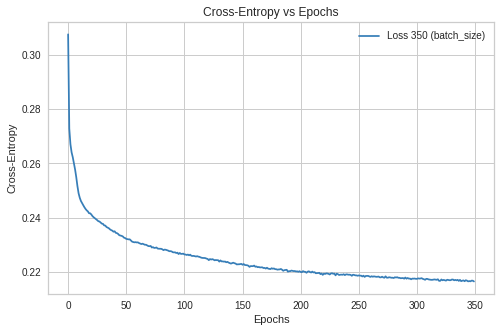

In [438]:
plot_loss(best_history, epochs)

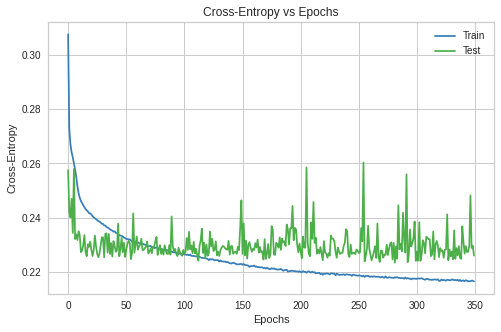

In [439]:
plot_loss_train_and_test(best_history)

In [442]:
# test_loss_1, test_acc_1 = best_model.evaluate(X_ts, y_ts.values.ravel())
# print('Loss %f, Accuracy %f' % (test_loss_1, test_acc_1))

/home/alexandra/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


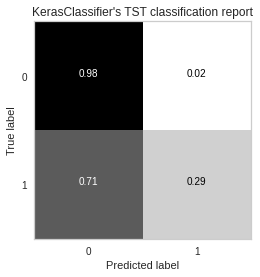

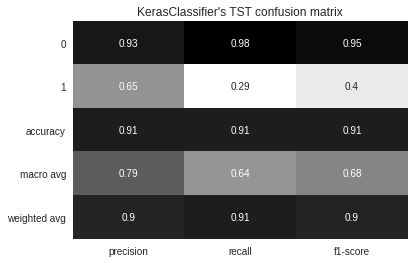

/home/alexandra/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


<Figure size 576x360 with 0 Axes>

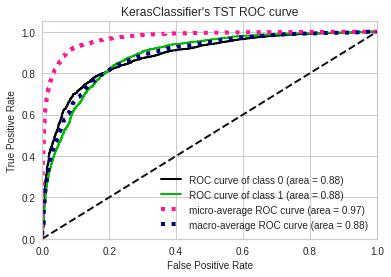

<Figure size 576x360 with 0 Axes>

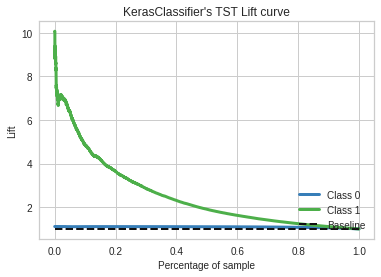

In [447]:
y_pred = best_model.predict_classes(X_ts)
cm = confusion_matrix(y_ts.values.ravel(), y_pred)
plot_confusion_matrix(cm, [0, 1], True)
plot_classification_report(y_ts.values.ravel(), y_pred)

y_prob = best_model.predict_proba(X_ts)

# print("roc", roc_auc_score(y_ts.values.ravel(), y_prob, average="weighted"))

plot_roc_curve(y_ts, y_prob)
plot_lift_curve_curve(y_ts, y_prob)

In [475]:
class Onehot2Int(object):

    def __init__(self, model):
        self.model = model

    def predict(self, X):
        y_pred = self.model.predict(X)
        return np.argmax(y_pred, axis=1)

In [474]:
def plot_decision_boundary2(scaled_X_tr, y, scaler, model):
    pca = PCA(n_components=2)
    X = pca.fit_transform(scaled_X_tr)

    # model.fit(X, y)
    plt.figure(figsize=(8, 5))
    print("ok")
    fig = plot_decision_regions(X=X, y=y, clf=model, legend=2)
    plt.xlabel("PCA component 1")
    plt.ylabel("PCA component 2")
    plt.title("%s's %s decision boundary" % (model_name, v_or_t_flag))
    plt.legend(loc='best')
    plt.grid(False)
    plt.show()

ok


ValueError: in user code:

    /home/alexandra/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1478 predict_function  *
        return step_function(self, iterator)
    /home/alexandra/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/alexandra/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/alexandra/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/alexandra/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/alexandra/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1461 run_step  **
        outputs = model.predict_step(data)
    /home/alexandra/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1434 predict_step
        return self(x, training=False)
    /home/alexandra/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/alexandra/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:255 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_186 is incompatible with the layer: expected axis -1 of input shape to have value 37 but received input with shape (32, 2)


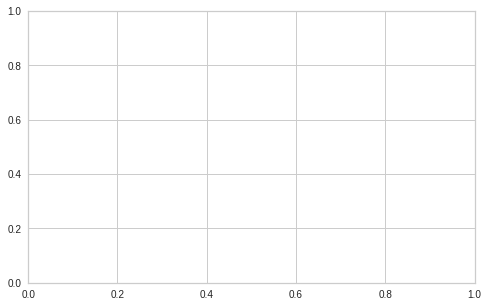

In [482]:
# Wrap keras model
model_no_ohe = Onehot2Int(best_model)
plot_decision_boundary2(X_tr, y_tr.values.ravel(), MinMaxScaler(), model_no_ohe)

In [484]:
def plot_learning_curve2(X_tr, y_tr, model, v_or_t_flag):
    second_score = ""
    if v_or_t_flag == 'VAL':
        cv = StratifiedKFold(n_splits=validation_n_splits)
        second_score = "Validation score"
    else:
        cv = StratifiedKFold(n_splits=test_n_splits)
        second_score = "Test score"
    sizes = np.linspace(0.3, 1.0, 10)
    plt.figure(figsize=(8, 5))
    visualizer = LearningCurve(model, cv=cv, scoring=scoring, train_sizes=sizes, 
                                                                       n_jobs=-1, random_state=random_state)

    visualizer.fit(X_tr, y_tr.values.ravel())    
    # visualizer.ax.get_lines()[1].set_label(second_score)
    visualizer.show() 

In [487]:
plot_learning_curve(X_tr, y_tr, clf, v_or_t_flag)

YellowbrickTypeError: Cannot detect the model name for non estimator: '<class 'tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier'>'

<Figure size 576x360 with 0 Axes>

<h2>Learning curves </h2>

This plotting is done at the end of the notebook, beacuse for some reason yellowbrick library overwrite scikitplot.

<h6>Saving best model on file</h6>

In [495]:
import pickle

model_info = {'model_name': 'Plain',
              'params': best_params,
              # 'tuned_model': best_tuned_model,
              'y_pred': y_pred,
              'y_prob': y_prob,
              # 'best_features': best_features,
              # 'best_features_scores': best_features_scores
             }

with open('pickle/' + model_name + '_1_layer_numeric.pickle', 'wb') as handle:
    pickle.dump(model_info, handle, protocol=pickle.HIGHEST_PROTOCOL)